# Pre-proj: check bias versus trends in multimodel ensemble
## Plot
conda env: `phd_v3` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period_past = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
seasons = ['Annual', 'DJFMA', 'JJAS']
# seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

var = 'tas'
table = u.get_table(var)
label, units, levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
label

'Near-Surface Air Temperature'

## Load topography

In [3]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Load obs
cru_ts4.00: https://crudata.uea.ac.uk/cru/data/hrg/

In [4]:
obs_longname = 'CRU TS v. 4.00'
obs_name = 'CRU'

obs = xr.open_dataset('/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.1901.2015.tmp.dat.nc').sel(
    time=period_past, lat=latlim_ext, lon=lonlim_ext).tmp

# Check if the time steps are ok
np.testing.assert_equal((int(period_past.stop) - int(period_past.start) + 1)*12, obs.time.size)

## Regrid obs towards the elevation grid of 1°x1°
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [5]:
regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
obs_regrid = regridder(obs)
obs_regrid.attrs['long_name'] = label
obs_regrid.attrs['units'] = units

Reuse existing file: bilinear_70x120_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


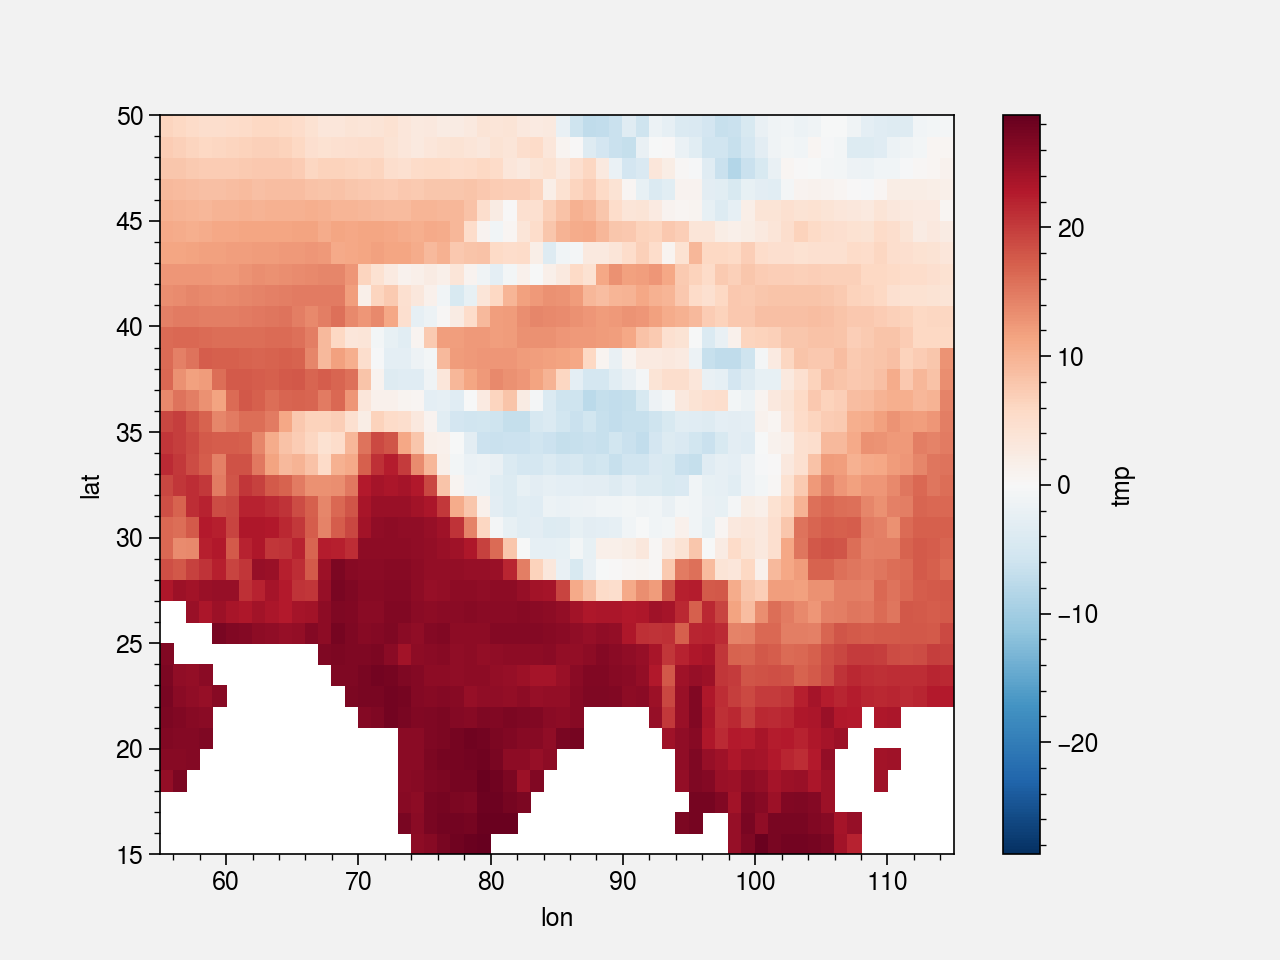

In [6]:
obs_regrid.mean('time').plot()

In [7]:
# obs_regrid

In [8]:
def corr(x, y, dim):
    return xr.apply_ufunc(
        stats.linregress, x, y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True
    )

In [9]:
# obs
ym_temp = []
for season in seasons:
    # Make annual mean
    ym = u.year_mean(obs_regrid, calendar='standard', season=season)

    # Compute trends
    for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym.year, ym, 'year')):
        ym[arr_name] = arr

    ym_temp.append(ym)

ym_obs = xr.concat(ym_temp, pd.Index(seasons, name='season'))

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


## Load models
Possible to load results direclty later

In [10]:
list_models = u.get_model_names()
# list_models = list_models[:10]
list_models

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAS-ESM2-0',
 'CESM2',
 'CESM2-FV2',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'GFDL-CM4',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NorESM2-LM',
 'SAM0-UNICON',
 'TaiESM1',
 'UKESM1-0-LL']

In [11]:
list_da = []

for model in list_models:
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    
    path = '/data/mlalande/CMIP6_HMA_paper'
    da = xr.open_dataarray(path+'/'+var+'/'+var+'_'+table+'_'+model+'_historical_ens_'+grid+'_197901-201412_HMA.nc')       
    
    list_da.append(da)

In [13]:
i = 25
list_da[i].realization

<xarray.DataArray 'realization' (realization: 16)>
array(['r10i1p1f2', 'r11i1p1f2', 'r12i1p1f2', 'r16i1p1f2', 'r17i1p1f2',
       'r18i1p1f2', 'r19i1p1f2', 'r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2',
       'r4i1p1f2', 'r5i1p1f3', 'r6i1p1f3', 'r7i1p1f3', 'r8i1p1f2', 'r9i1p1f2'],
      dtype=object)
Coordinates:
  * realization  (realization) object 'r10i1p1f2' 'r11i1p1f2' ... 'r9i1p1f2'

In [20]:
i = 10
print(list_models[i])
list_da[i].where(list_da[i].realization.str.contains('r*i1p2f1'), drop=True).realization

CanESM5


<xarray.DataArray 'realization' (realization: 40)>
array(['r10i1p2f1', 'r11i1p2f1', 'r12i1p2f1', 'r13i1p2f1', 'r14i1p2f1',
       'r15i1p2f1', 'r16i1p2f1', 'r17i1p2f1', 'r18i1p2f1', 'r19i1p2f1',
       'r1i1p2f1', 'r20i1p2f1', 'r21i1p2f1', 'r22i1p2f1', 'r23i1p2f1',
       'r24i1p2f1', 'r25i1p2f1', 'r26i1p2f1', 'r27i1p2f1', 'r28i1p2f1',
       'r29i1p2f1', 'r2i1p2f1', 'r30i1p2f1', 'r31i1p2f1', 'r32i1p2f1',
       'r33i1p2f1', 'r34i1p2f1', 'r35i1p2f1', 'r36i1p2f1', 'r37i1p2f1',
       'r38i1p2f1', 'r39i1p2f1', 'r3i1p2f1', 'r40i1p2f1', 'r4i1p2f1',
       'r5i1p2f1', 'r6i1p2f1', 'r7i1p2f1', 'r8i1p2f1', 'r9i1p2f1'],
      dtype=object)
Coordinates:
  * realization  (realization) object 'r10i1p2f1' 'r11i1p2f1' ... 'r9i1p2f1'

## Compute trends

In [23]:
%%time

# model
ym_list = []
ens_list = []

# for i, model in enumerate(list_models[:2]):
for i, model in enumerate(list_models):
    print(model)
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    
    if model == 'CanESM5':
        da = list_da[i].where(list_da[i].realization.str.contains('r*i1p2f1'), drop=True)
    elif model == 'GISS-E2-1-G':
        da = list_da[i].sel(realization=['r10i1p1f1', 'r10i1p1f2',
               'r1i1p1f1', 'r1i1p1f2', 'r2i1p1f1', 'r2i1p1f2', 'r3i1p1f1', 'r3i1p1f2',
               'r4i1p1f1', 'r4i1p1f2', 'r5i1p1f1', 'r5i1p1f2', 'r6i1p1f1', 'r6i1p1f2',
               'r7i1p1f1', 'r7i1p1f2', 'r8i1p1f1', 'r8i1p1f2', 'r9i1p1f1', 'r9i1p1f2'])
    elif model == 'GISS-E2-1-H':
        da = list_da[i].where(list_da[i].realization.str.contains('r*i*p1f(?:1|2)'), drop=True)
    elif model == 'MRI-ESM2-0':
        da = list_da[i].where(list_da[i].realization.str.contains('r*i1p1f1'), drop=True)
    elif model == 'UKESM1-0-LL':
        da = list_da[i].where(list_da[i].realization.str.contains('r*i1p1f2'), drop=True)
    else:
        da = list_da[i]
    
    ym_temp = []
    ens_temp = []
    for season in seasons:
        # Make annual mean
        ym = u.year_mean(da, calendar=calendar, season=season)
        ens = ym.mean('realization')
        
        # Compute trends
        for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym.year, ym, 'year')):
            ym[arr_name] = arr
            
        for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ens.year, ens, 'year')):
            ens[arr_name] = arr
        
        ym_temp.append(ym)
        ens_temp.append(ens)
        
        # Compute bias
        ym['bias'] = ym.mean('year') - ym_obs.sel(season=season).mean('year')
        
    concat = xr.concat(ym_temp, pd.Index(seasons, name='season'))
    concat_ens = xr.concat(ens_temp, pd.Index(seasons, name='season'))
    
    ym_list.append(concat)
    ens_list.append(concat_ens)

BCC-CSM2-MR


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


BCC-ESM1


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAS-ESM2-0


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CESM2


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CESM2-FV2


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CESM2-WACCM


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CESM2-WACCM-FV2


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CNRM-CM6-1


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CNRM-CM6-1-HR


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CNRM-ESM2-1


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CanESM5


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


GFDL-CM4


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


GISS-E2-1-G


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


GISS-E2-1-H


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HadGEM3-GC31-LL


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HadGEM3-GC31-MM


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


IPSL-CM6A-LR


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


MIROC-ES2L


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


MIROC6


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


MPI-ESM1-2-HR


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


MPI-ESM1-2-LR


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


MRI-ESM2-0


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


NorESM2-LM


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


SAM0-UNICON


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


TaiESM1


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


UKESM1-0-LL


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 10min 12s, sys: 10.7 s, total: 10min 23s
Wall time: 11min 9s


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Save results

In [31]:
i = 25
print(list_models[i])
ym_list[i].realization

UKESM1-0-LL


<xarray.DataArray 'realization' (realization: 13)>
array(['r10i1p1f2', 'r11i1p1f2', 'r12i1p1f2', 'r16i1p1f2', 'r17i1p1f2',
       'r18i1p1f2', 'r19i1p1f2', 'r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2',
       'r4i1p1f2', 'r8i1p1f2', 'r9i1p1f2'], dtype=object)
Coordinates:
  * realization  (realization) object 'r10i1p1f2' 'r11i1p1f2' ... 'r9i1p1f2'

In [32]:
for i, model in enumerate(list_models):
    print(model)
    ym_list[i].to_netcdf('results/ym/'+var+'/'+var+'_'+model+'_historical_ym_trend-bias_197901-201412_HMA.nc')
    ens_list[i].to_netcdf('results/ym/'+var+'/'+var+'_'+model+'_historical_ym-ens_trend-bias_197901-201412_HMA.nc')

BCC-CSM2-MR
BCC-ESM1
CAS-ESM2-0
CESM2
CESM2-FV2
CESM2-WACCM
CESM2-WACCM-FV2
CNRM-CM6-1
CNRM-CM6-1-HR
CNRM-ESM2-1
CanESM5
GFDL-CM4
GISS-E2-1-G
GISS-E2-1-H
HadGEM3-GC31-LL
HadGEM3-GC31-MM
IPSL-CM6A-LR
MIROC-ES2L
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NorESM2-LM
SAM0-UNICON
TaiESM1
UKESM1-0-LL


## Load results

In [15]:
# model
ym_list = []
ens_list = []

# for i, model in enumerate(list_models[:2]):
for i, model in enumerate(list_models):
    print(model)
    concat = xr.open_dataarray('results/ym/'+var+'/'+var+'_'+model+'_historical_ym_trend-bias_197901-201412_HMA.nc')
    concat_ens = xr.open_dataarray('results/ym/'+var+'/'+var+'_'+model+'_historical_ym-ens_trend-bias_197901-201412_HMA.nc')
    
    ym_list.append(concat)
    ens_list.append(concat_ens)

BCC-CSM2-MR
BCC-ESM1
CAS-ESM2-0
CESM2
CESM2-FV2
CESM2-WACCM
CESM2-WACCM-FV2
CNRM-CM6-1
CNRM-CM6-1-HR
CNRM-ESM2-1
CanESM5
CanESM5-CanOE
GFDL-CM4
GISS-E2-1-G
GISS-E2-1-H
HadGEM3-GC31-LL
HadGEM3-GC31-MM
IPSL-CM6A-LR
MIROC-ES2L
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NorESM2-LM
SAM0-UNICON
TaiESM1
UKESM1-0-LL


In [32]:
# ym_list[10].realization
# ens_list[1]

## Compute the multimodel mean (for first member)

In [63]:
ensemble_r0 = xr.concat([ym_list[i].isel(realization=0) for i in range(len(list_models))], pd.Index(list_models, name='model'))
ensemble_r0_mean = ensemble_r0.mean('model').isel(year=slice(0,-1))

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [64]:
ensemble_r0_mean

<xarray.DataArray (season: 3, year: 35, lat: 25, lon: 50)>
array([[[[25.14609389, 24.99346843, 24.96664274, ..., 23.88045476,
          24.1338654 , 24.25861333],
         [25.53012059, 25.19133322, 25.06430944, ..., 22.46700749,
          22.96011775, 23.22739555],
         [26.00079448, 25.51707938, 25.26484015, ..., 20.89125303,
          21.41452342, 21.66961774],
         ...,
         [13.51956453, 13.44288453, 13.34205289, ...,  5.49488036,
           5.20008677,  4.75638351],
         [12.40301107, 12.49816535, 12.44975602, ...,  4.73304897,
           4.78533568,  4.55710632],
         [11.33368423, 11.44176418, 11.57006721, ...,  3.4779456 ,
           3.64606901,  3.61061882]],

        [[25.14122497, 24.99559265, 24.95985537, ..., 23.86485025,
          24.10194657, 24.2429864 ],
         [25.52102464, 25.18062913, 25.04430241, ..., 22.51755034,
          22.99127179, 23.23751809],
         [26.01951529, 25.51304823, 25.25059154, ..., 20.9670288 ,
          21.48593075, 21.7169353 ],
...
         [28.49371447, 28.56866536, 28.49411511, ..., 21.85597332,
          21.51656372, 21.01295404],
         [27.21764815, 27.6864231 , 27.79904199, ..., 21.52219824,
          21.64412884, 21.38856297],
         [25.99824825, 26.52379798, 27.0998008 , ..., 20.52552845,
          20.82418672, 20.88817507]],

        [[26.97556242, 26.75007313, 26.74946123, ..., 28.80047105,
          28.96323076, 29.04151337],
         [28.01947894, 27.31029148, 27.0926034 , ..., 27.92026517,
          28.40765896, 28.5983467 ],
         [29.38969677, 28.22859167, 27.7041142 , ..., 26.87372367,
          27.42622999, 27.65891428],
         ...,
         [28.43197133, 28.52371092, 28.48191256, ..., 22.05307474,
          21.73098632, 21.23737153],
         [27.18886432, 27.66958637, 27.78128328, ..., 21.67506196,
          21.82904353, 21.61123372],
         [26.01113473, 26.53813708, 27.10753077, ..., 20.62677885,
          20.94742696, 21.0440063 ]]]])
Coordinates:
  * season   (season) object 'Annual' 'DJFMA' 'JJAS'
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2009 2010 2011 2012 2013
  * lon      (lon) float32 60.5 61.5 62.5 63.5 64.5 ... 106.5 107.5 108.5 109.5
  * lat      (lat) float32 20.5 21.5 22.5 23.5 24.5 ... 40.5 41.5 42.5 43.5 44.5

In [65]:
for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ensemble_r0_mean.year, ensemble_r0_mean, 'year')):
    ensemble_r0_mean[arr_name] = arr

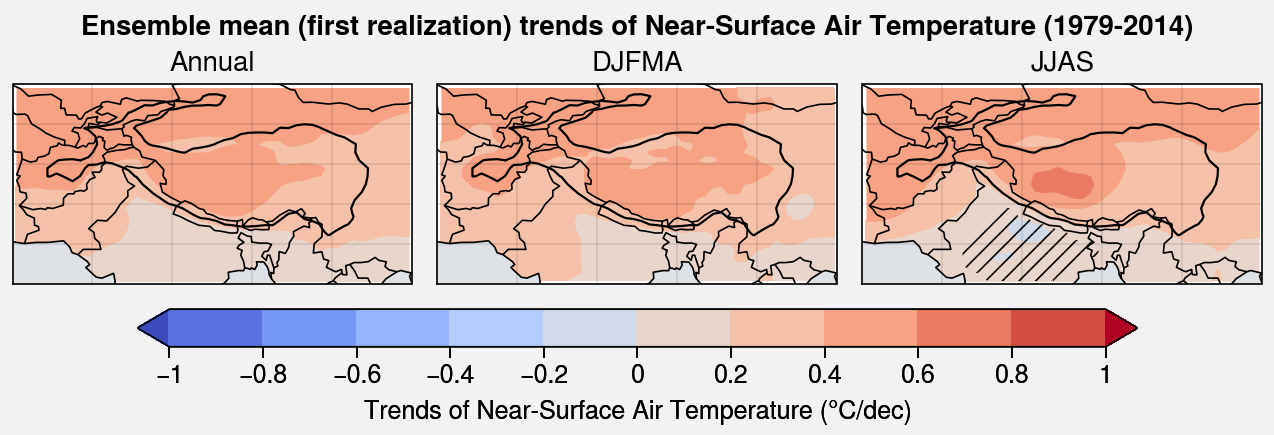

In [72]:
cmap = 'CoolWarm'
levels = plot.arange(-1,1,0.2)
extend = 'both'

f, axs = plot.subplots(proj='cyl', ncols=3, nrows=1, axwidth=2)

for ax, season in zip(axs, seasons):
    
    # Add contour 2500 m
    ax.contour(elevation, levels=[2500], color='black', linewidth=0.8)

    # Plot model bias
    m = ax.contourf(
        ensemble_r0_mean.sel(season=season).slope*10, cmap=cmap, levels=levels, extend=extend
    )

    # pvalue
    pvalue = ensemble_r0_mean.sel(season=season).pvalue
    ax.contourf(pvalue.where(pvalue>0.05), hatches=['////'], alpha=0)

    # Text
    ax.format(title=season)

f.colorbar(m, label='Trends of '+label+' ('+units+'/dec)', loc='b', length=0.8)

axs.format(
    # Grids, labels and limits
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),

    # Add coast, ocean, borders
    coast=True, ocean=True, oceancolor='gray3', borders=True,

    # Suptitle
    suptitle='Ensemble mean (first realization) trends of '+label+' ('+period_past.start+'-'+period_past.stop+')'   
)

filename = 'EM_trends_'+var+'_'+period_past.start+'-'+period_past.stop
f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

## Make plots for all

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/proplot/axes/plot.py:2684: UserWarning: Warning: converting a masked element to nan.
  vmin = float(data.min())
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/proplot/axes/plot.py:2686: UserWarning: Warning: converting a masked element to nan.
  vmax = float(data.max())
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/matplotlib/contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/matplotlib/contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/proplot/axes/plot.py:2684: UserWarning: Warning: converting a masked element to nan.
  vmin = float(data.min())
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/proplot/axes/plot.py:2686: UserWarning

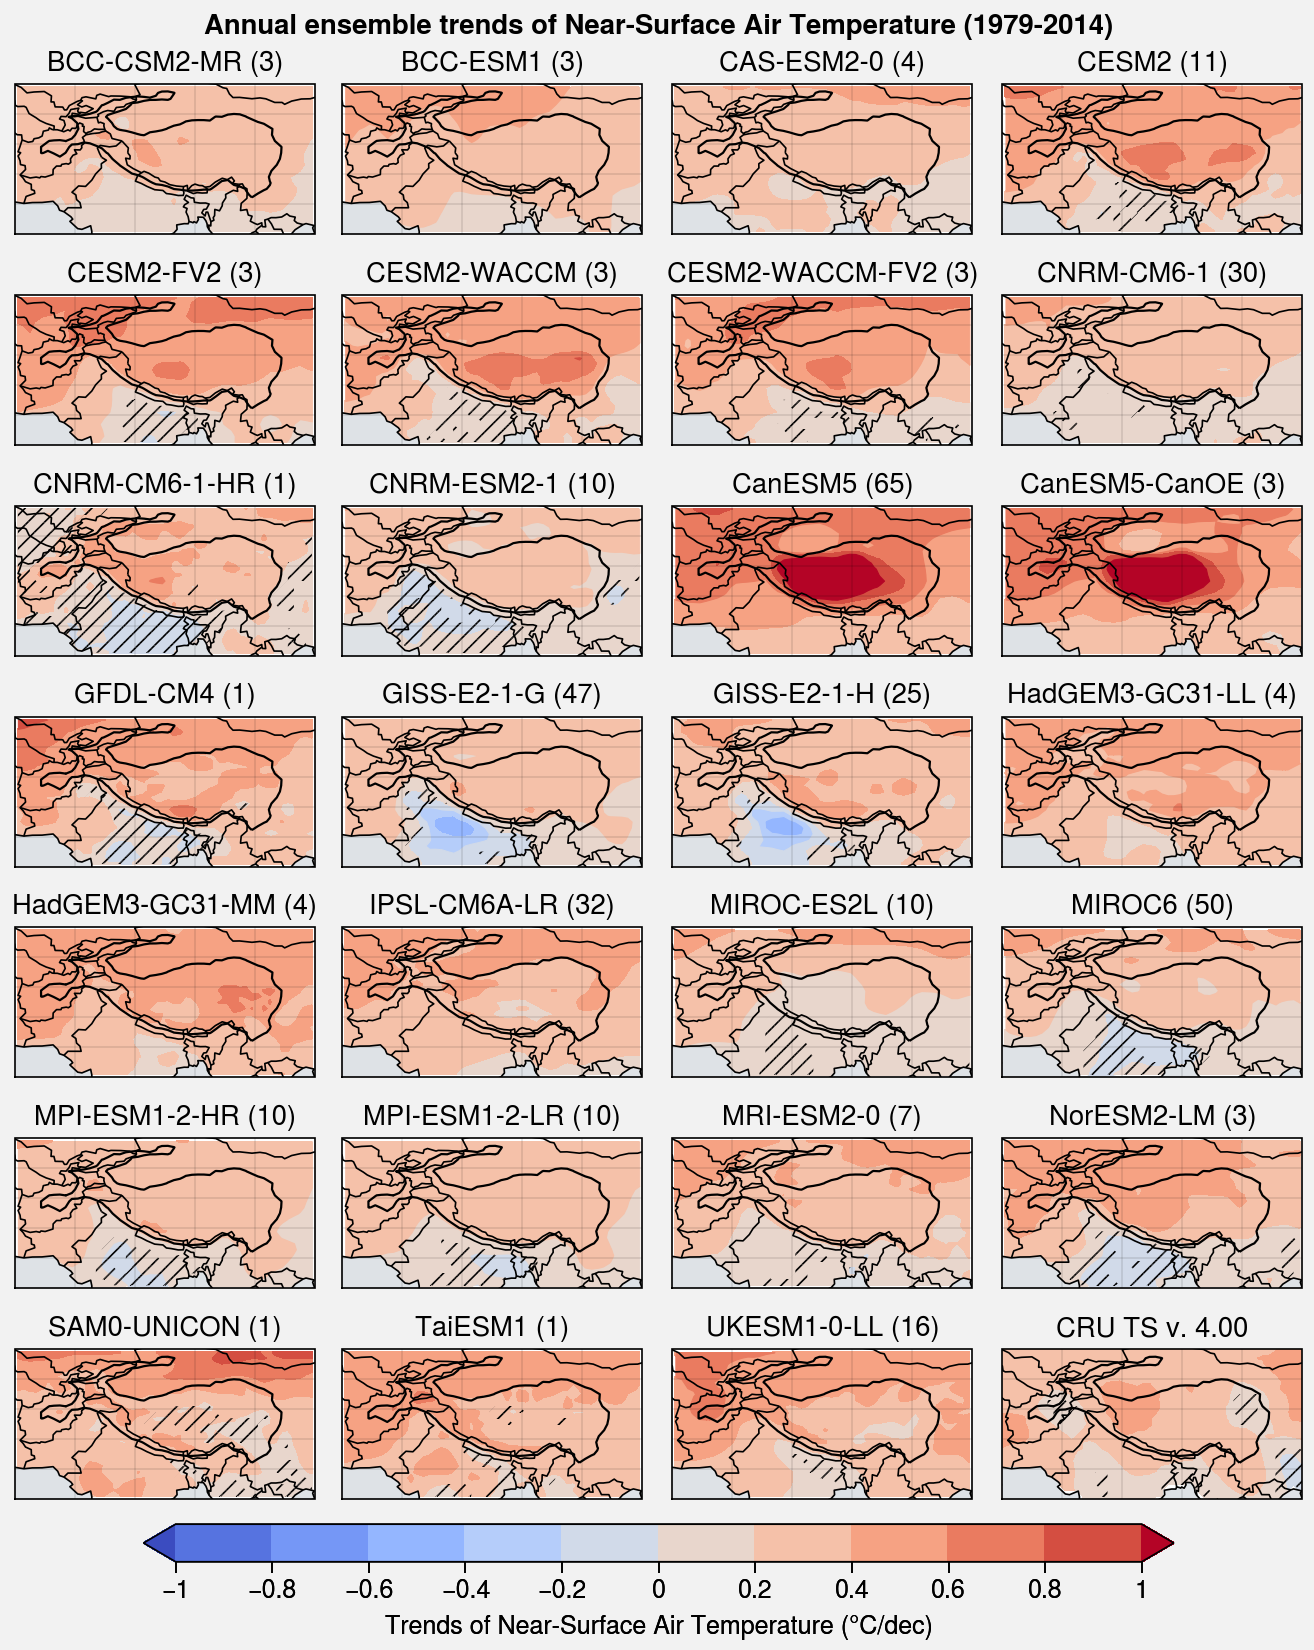

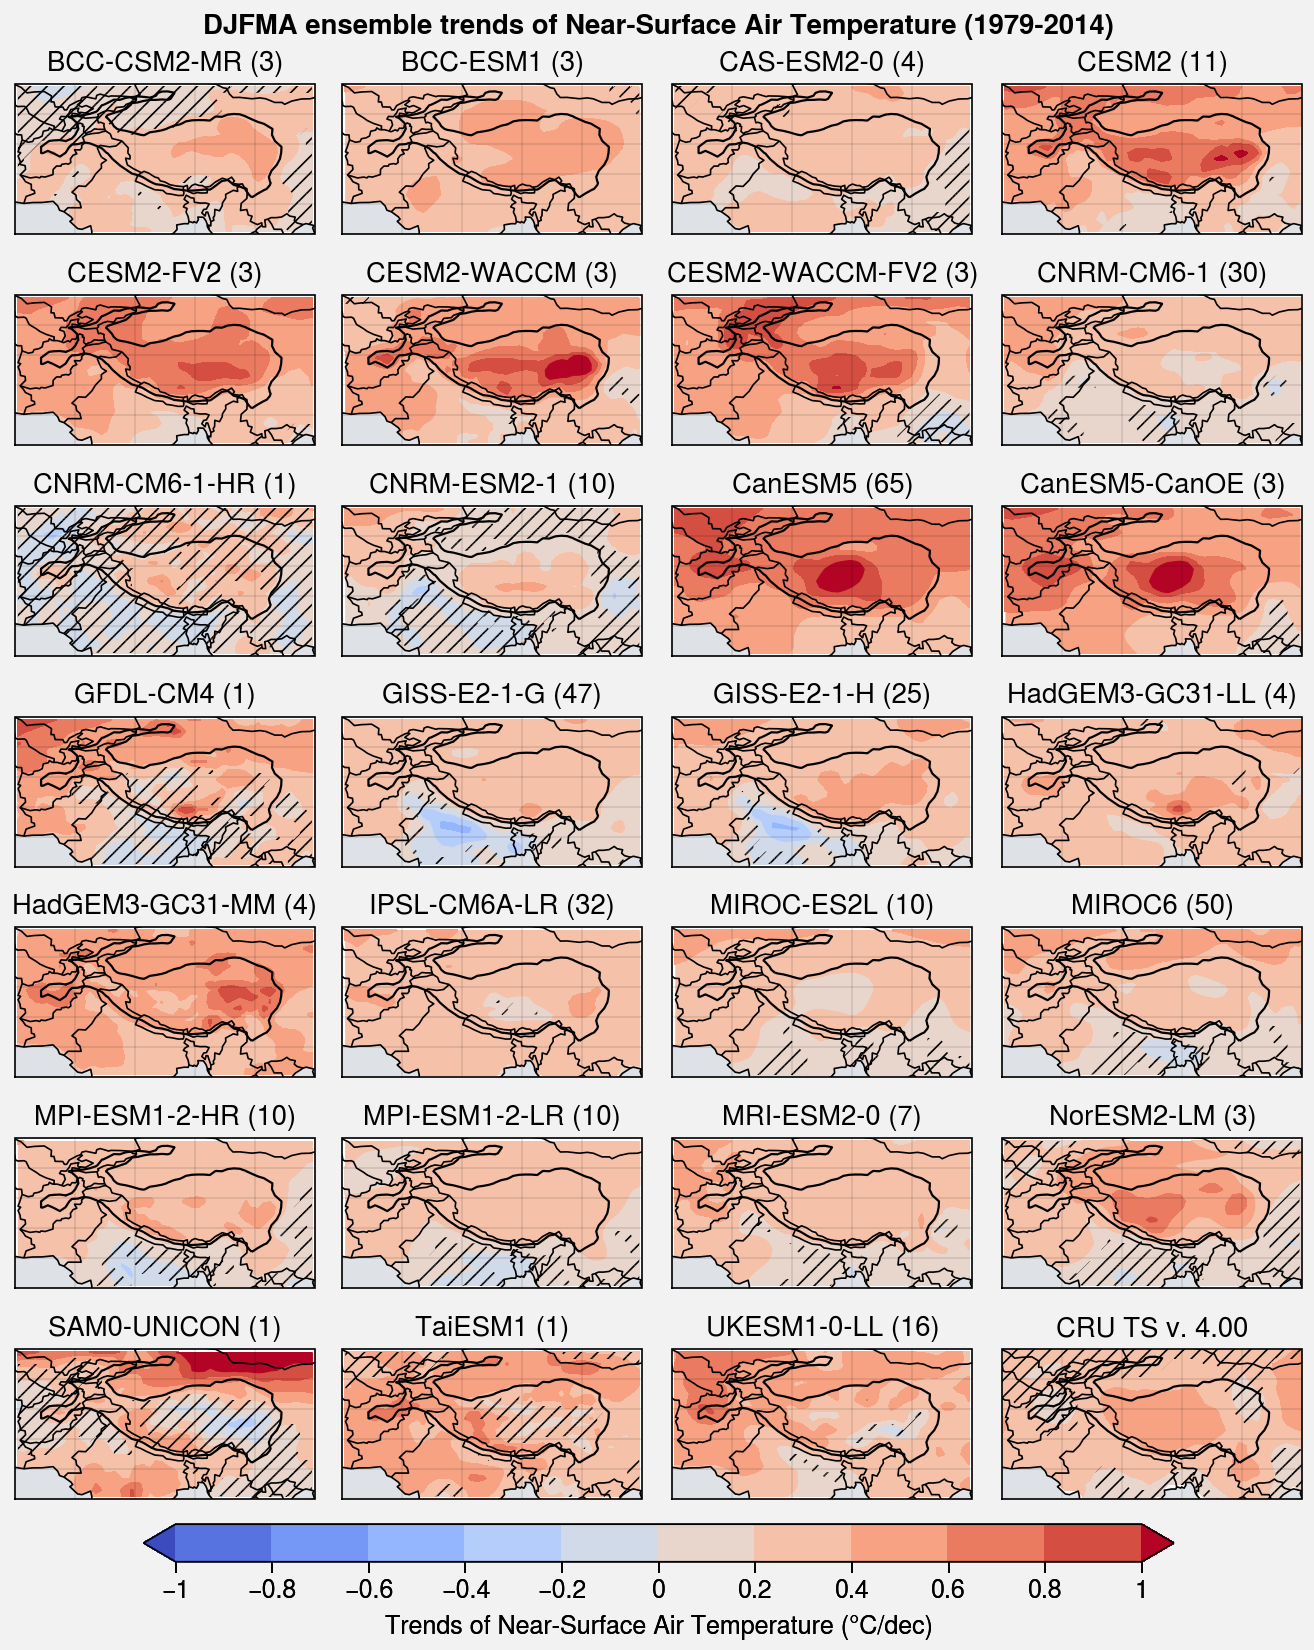

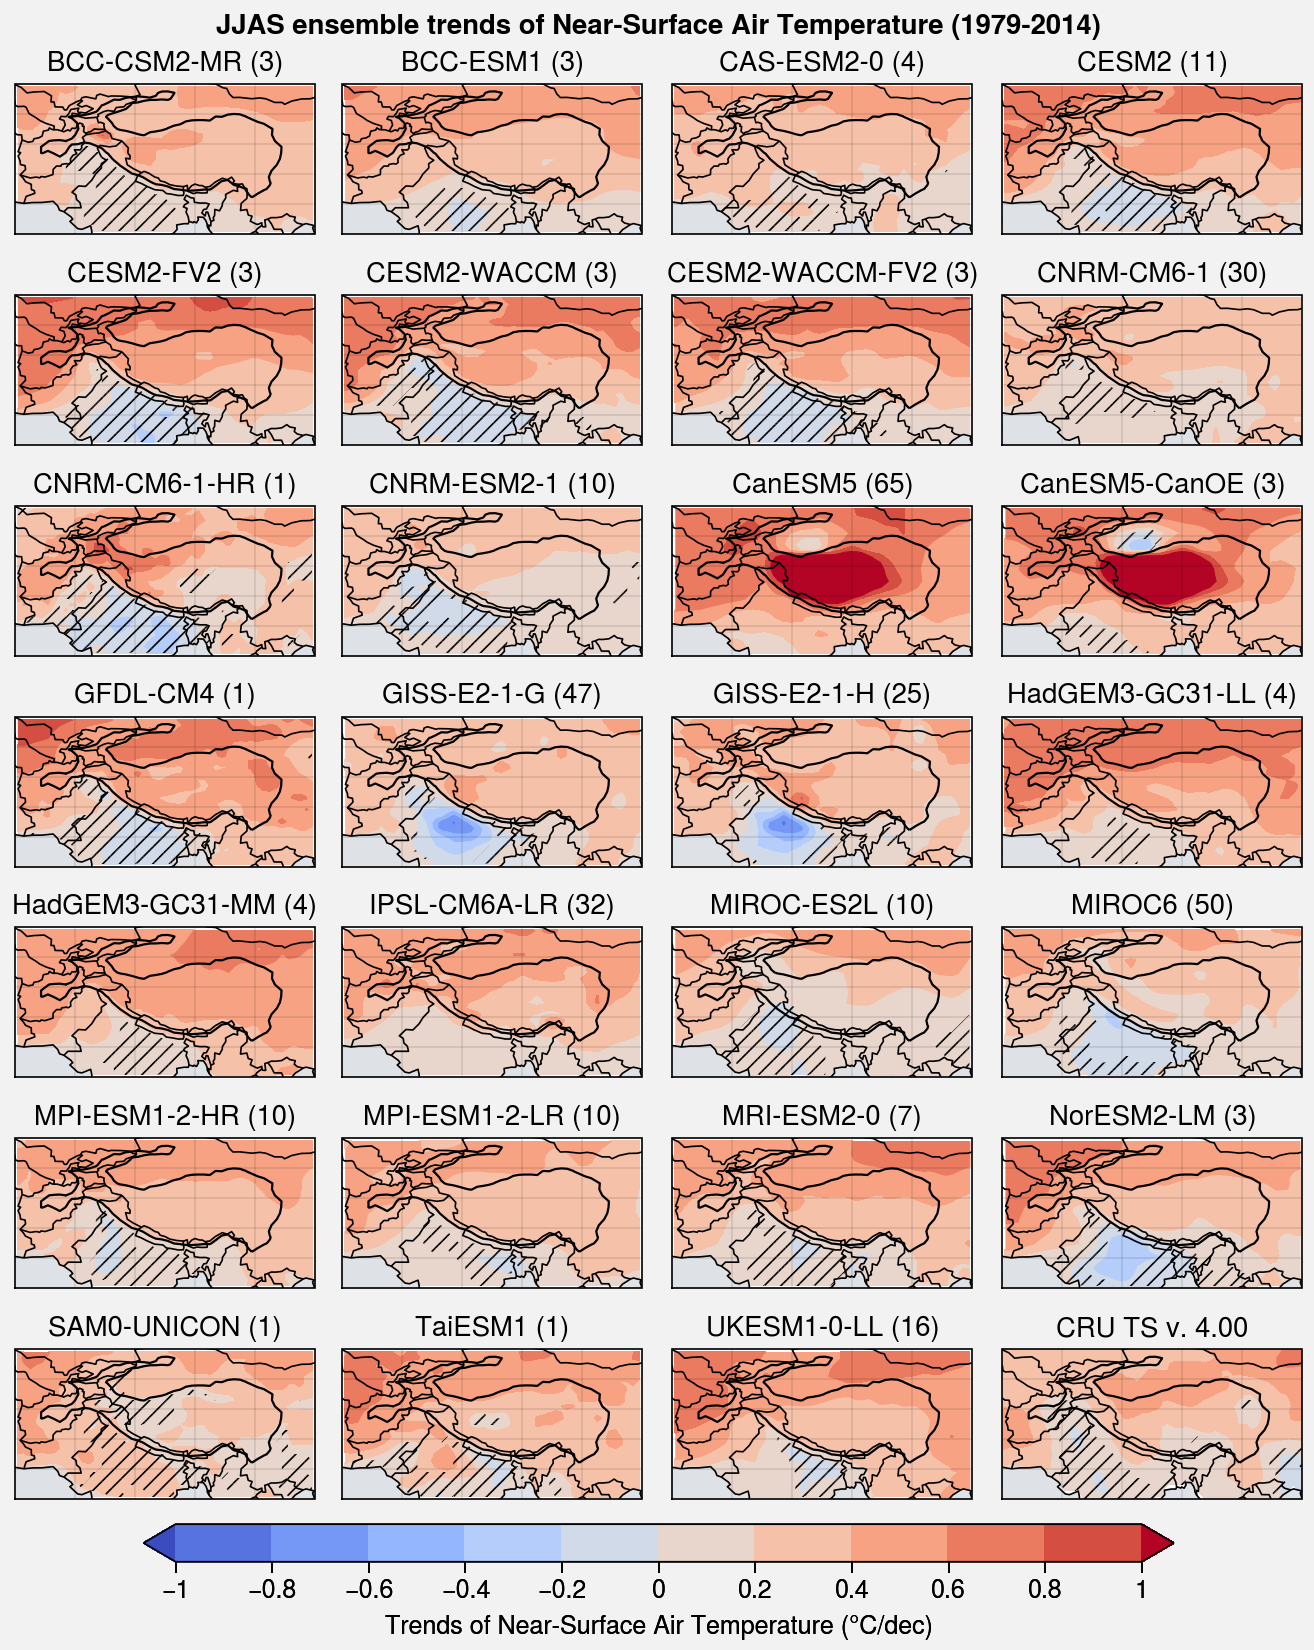

In [13]:
cmap = 'CoolWarm'
levels = plot.arange(-1,1,0.2)
extend = 'both'

for season in seasons:
# for season in ['Annual']:
    f, axs = plot.subplots(proj='cyl', ncols=4, nrows=7, axwidth=1.5)
    
    # Plot observation
    last = len(axs)-1
    axs[last].contour(elevation, levels=[2500], color='black', linewidth=0.8)
    m = axs[last].contourf(
        ym_obs.sel(season=season).slope*10, cmap=cmap, levels=levels, extend=extend
    )
    pvalue = ym_obs.sel(season=season).pvalue
    axs[last].contourf(pvalue.where(pvalue>0.05), hatches=['////'], alpha=0)
    axs[last].format(title=obs_longname)
    
    for i, model in enumerate(list_models):
        # Add contour 2500 m
        axs[i].contour(elevation, levels=[2500], color='black', linewidth=0.8)

        # Plot model bias
        m = axs[i].contourf(
            ens_list[i].sel(season=season).slope*10, cmap=cmap, levels=levels, extend=extend
        )
        
        # pvalue
        pvalue = ens_list[i].sel(season=season).pvalue
        axs[i].contourf(pvalue.where(pvalue>0.05), hatches=['////'], alpha=0)

        # Text
        axs[i].format(title=model+' ('+str(ym_list[i].realization.size)+')')

    f.colorbar(m, label='Trends of '+label+' ('+units+'/dec)', loc='b', length=0.8)

    axs.format(
        # Grids, labels and limits
        labels=False, lonlines=10, latlines=5, 
        latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
        
        # Add coast, ocean, borders
        coast=True, ocean=True, oceancolor='gray3', borders=True,
        
        # Suptitle
        suptitle=season+' ensemble trends of '+label+' ('+period_past.start+'-'+period_past.stop+')'   
    )
    
    filename = season+'_trends_'+var+'_'+period_past.start+'-'+period_past.stop
    f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

# Bias versus trends

Annual
HMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HK


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HM


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


TP


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


DJFMA
HMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HK


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HM


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


TP


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


JJAS
HMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HK


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HM


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


TP


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


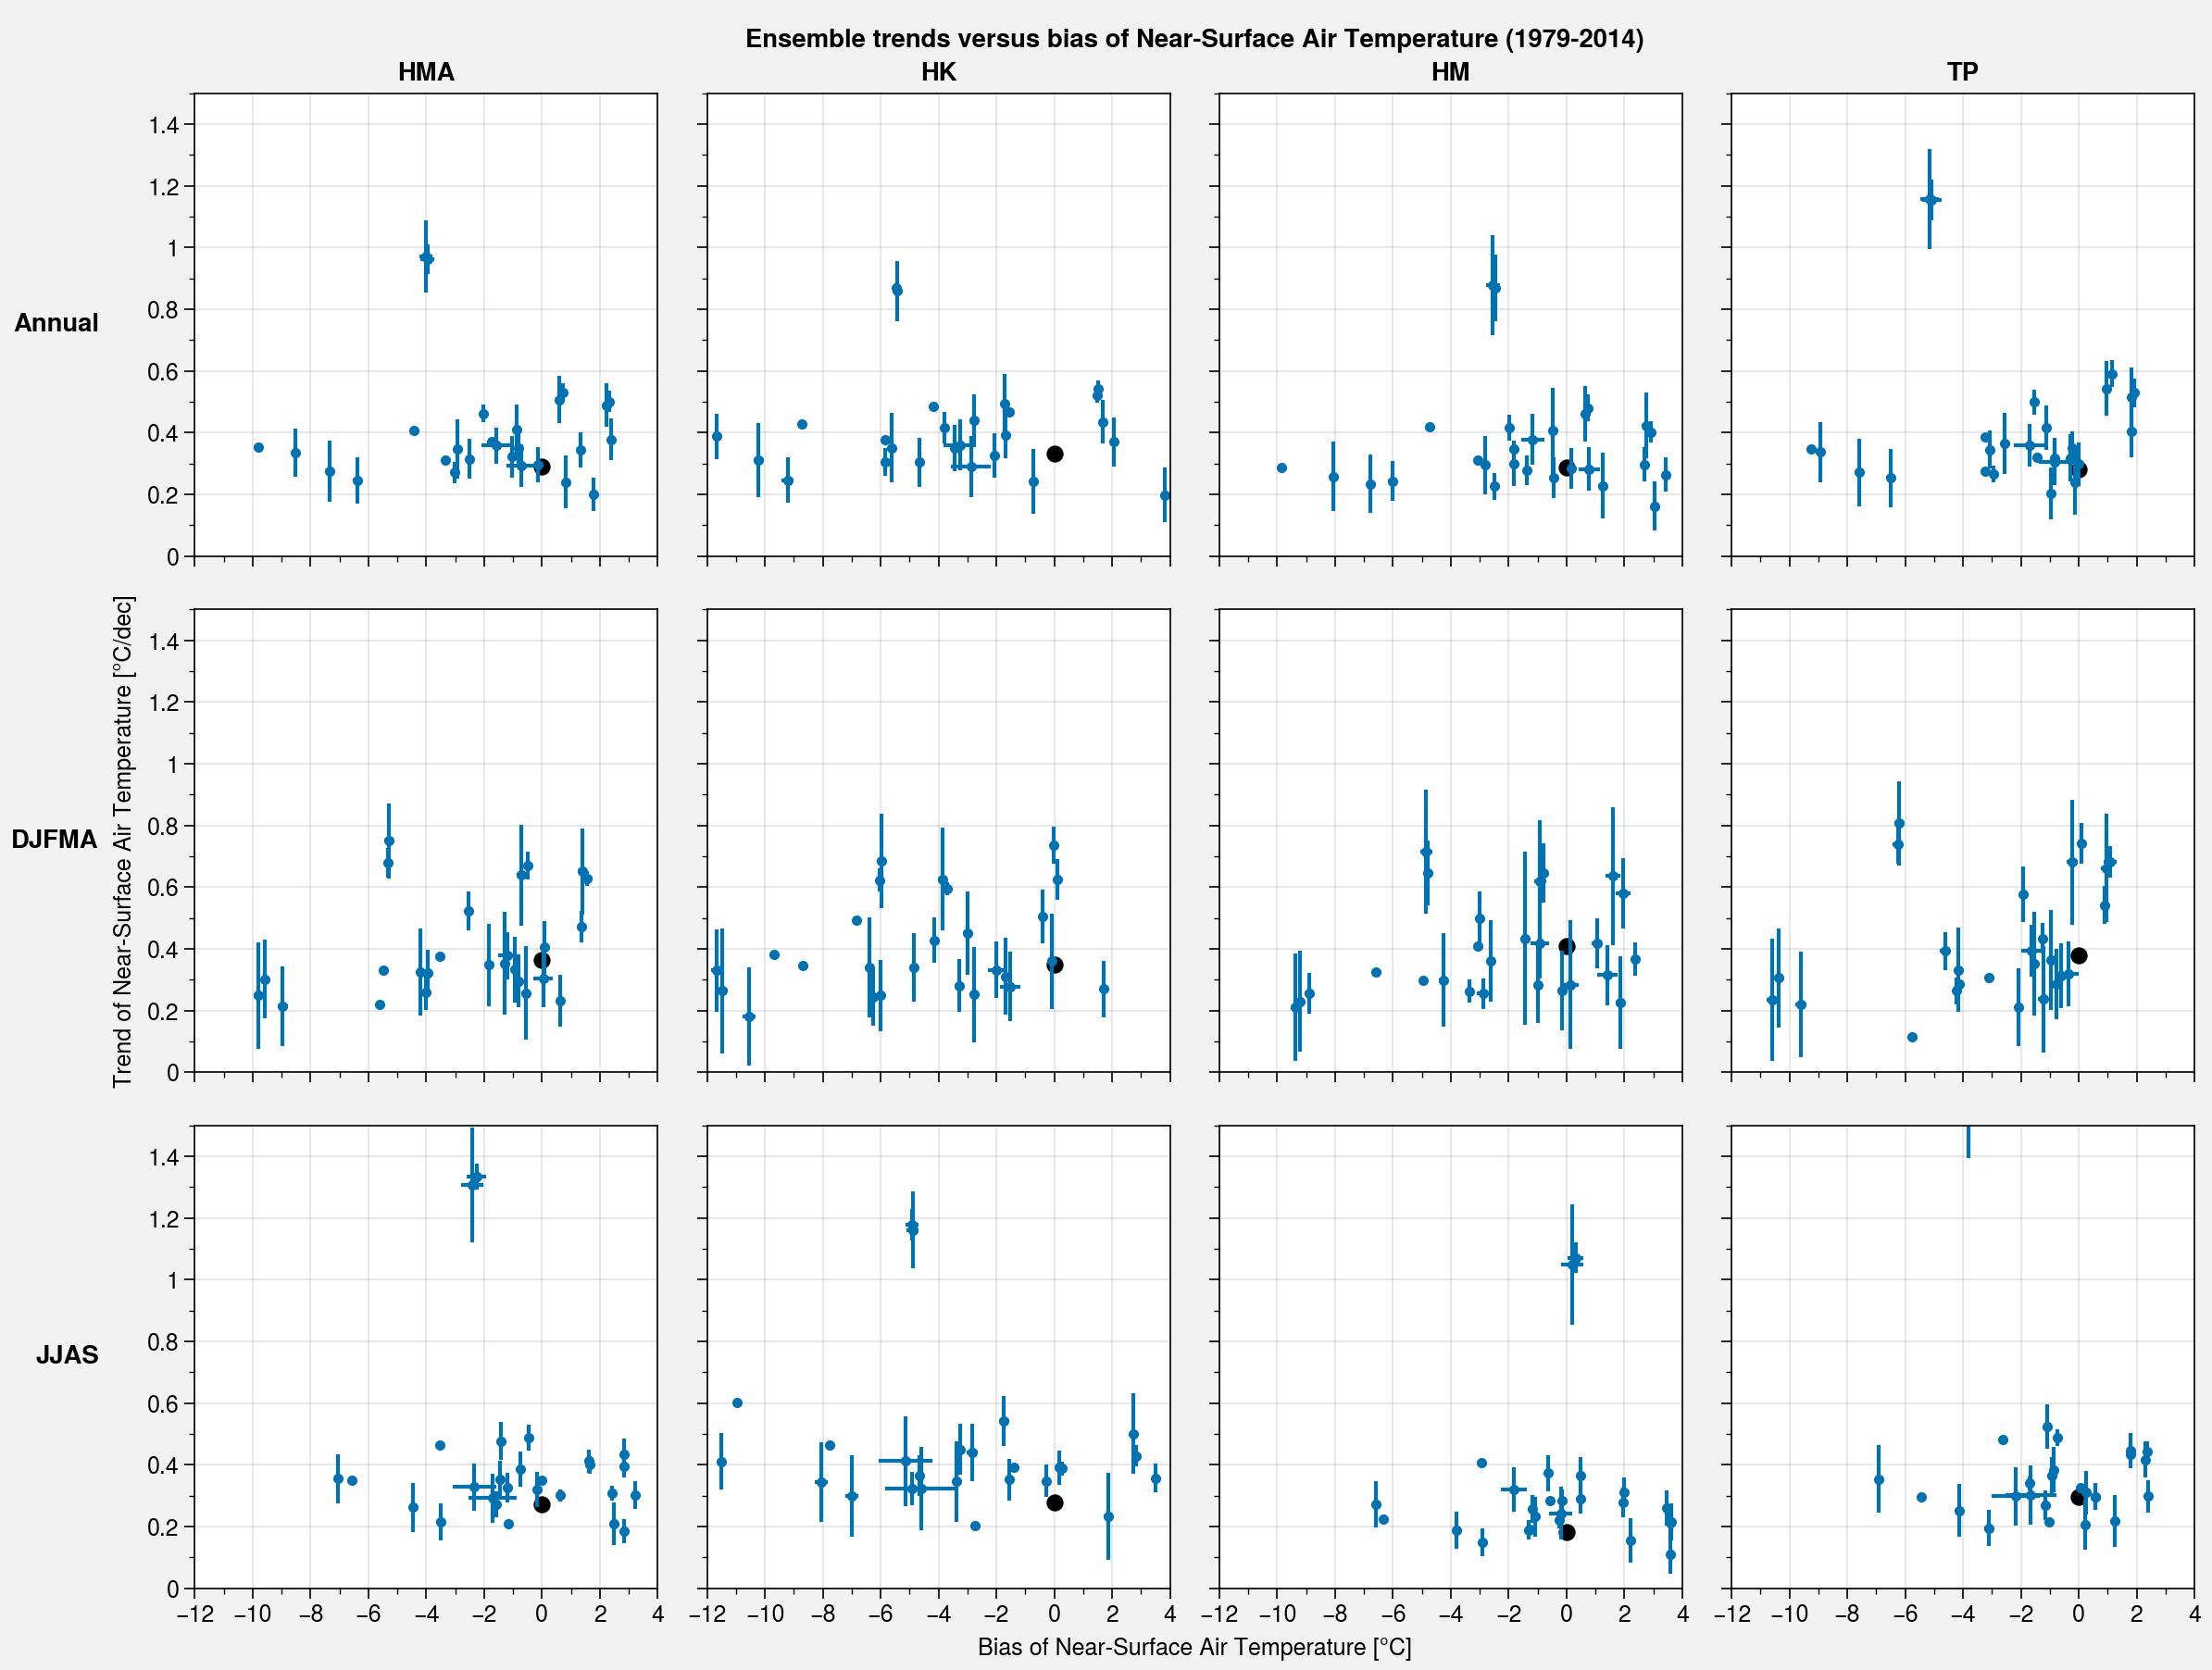

In [81]:
fig, axs = plot.subplots(ncols=4, nrows=3)

k=0
for season in seasons[:]:
    print(season)
    for zone in zones[:]:
        print(zone)
        for i, model in enumerate(list_models[:]):
#             print(str(i) + ' : ' + model)

            ym = ym_list[i].copy()

            # Check if values are not nan
            for realization in ym.slope.realization.values:
                if np.isnan(ym.slope[0].sel(realization=realization).mean()):
                    ym = ym.drop_sel(realization=realization)

            
            # models
            slope = u.spatial_average(
                ym.slope.sel(
                    lat=zones_df.loc[zone, 'latlim'], 
                    lon=zones_df.loc[zone, 'lonlim']
                ).where(elevation > 2500)
            )

            bias = u.spatial_average(
                ym.bias.sel(
                    lat=zones_df.loc[zone, 'latlim'], 
                    lon=zones_df.loc[zone, 'lonlim']
                ).where(elevation > 2500)
            )


            axs[k].errorbar(
                bias.sel(season=season).mean('realization'),
                (slope.sel(season=season)*10).mean('realization'), 
                yerr=(slope.sel(season=season)*10).std('realization'), 
                xerr=bias.sel(season=season).std('realization'),
                fmt='.C0'
            )
            
        # obs
        slope = u.spatial_average(
            ym_obs.slope.sel(
                lat=zones_df.loc[zone, 'latlim'], 
                lon=zones_df.loc[zone, 'lonlim']
            ).where(elevation > 2500)
        )

        axs[k].scatter(
            0, (slope.sel(season=season)*10),
            marker='o', color='k'
        )
            
            
            
        k += 1

axs.format(
    xlabel='Bias of '+label+' ['+units+']',
    ylabel='Trend of '+label+' ['+units+'/dec]',
    suptitle='Ensemble trends versus bias of '+label+' ('+period_past.start+'-'+period_past.stop+')',
    collabels=zones,
    rowlabels=seasons,
    ylim=(0,1.5), ylocator=0.2, yminorlocator=0.1,
    xlim=(-12,4), xlocator=2, xminorlocator=1.0000001,
)

filename = 'trends-vs-bias_'+var+'_'+period_past.start+'-'+period_past.stop
fig.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')